# Notebook for benchmarking different variational approaches in solving a QUBO

In [14]:
from aquapointer.digital.loaddata import LoadData
from aquapointer.digital.qubo import Qubo
from aquapointer.digital.vqe import VQE
from aquapointer.digital.ansatz import QAOA_ansatz

# General imports
import numpy as np
import pickle

# Pre-defined ansatz circuit, operator class
from qiskit.circuit.library import QAOAAnsatz, TwoLocal
from qiskit.primitives import BackendSampler
from qiskit import QuantumCircuit, transpile 
from qiskit_aer import AerSimulator

backend = AerSimulator()
sampler = BackendSampler(backend=backend, options={"shots": int(1e4)})

In [15]:
# LoadData does all the file loading
ld = LoadData(protein='MUP1')

# Qubo computes all the qubo matrices given the 3d rism files and rescaled positions of registers from LoadData.
q = Qubo(ld.densities, ld.rescaled_register_positions)

In [16]:
# use the first slice as an example to solve
qubo, ising_ham = q.qubo_hamiltonian_pairs[1]
num_qubits = len(qubo)

# TwoLocal ansatz circuit
le_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)
qubo

array([[-0.02881146,  0.04727714,  0.04727714,  0.03218907,  0.03218907,
         0.02656055,  0.01492186,  0.01492186,  0.00570776],
       [ 0.04727714, -0.03523304,  0.04727714,  0.04727714,  0.02656055,
         0.03218907,  0.01015968,  0.01492185,  0.00470971],
       [ 0.04727714,  0.04727714, -0.04167669,  0.04727714,  0.04727714,
         0.04727714,  0.02656054,  0.03218904,  0.0149218 ],
       [ 0.03218907,  0.04727714,  0.04727714, -0.03632582,  0.03218907,
         0.04727711,  0.01492184,  0.02656045,  0.01015953],
       [ 0.03218907,  0.02656055,  0.04727714,  0.03218907, -0.03937356,
         0.04727711,  0.0472771 ,  0.04727697,  0.03218859],
       [ 0.02656055,  0.03218907,  0.04727714,  0.04727711,  0.04727711,
        -0.04088436,  0.03218895,  0.04727645,  0.02655908],
       [ 0.01492186,  0.01015968,  0.02656054,  0.01492184,  0.0472771 ,
         0.03218895, -0.03256398,  0.04727644,  0.04727444],
       [ 0.01492186,  0.01492185,  0.03218904,  0.02656045,  0

In [17]:
qubo, ising_ham = q.qubo_hamiltonian_pairs[5]

from scipy.optimize import minimize
def quadratic_function(x, sigma, mu):
    return x.T @ sigma @ x + mu.T @ x


bounds = [(0, 1)] * len(qubo)
x0 = np.zeros(len(qubo))

result = minimize(quadratic_function, x0, args=(qubo - np.diag(np.diagonal(qubo)), np.diagonal(qubo)), bounds=bounds)
x_stars = result.x
x_stars, quadratic_function(x_stars, qubo - np.diag(np.diagonal(qubo)), np.diagonal(qubo))

(array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.3457896e-19,
        0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00]),
 -0.023073821946831514)

In [18]:
[('1000', -0.010743767178636635),
 ('010000001', -0.05676551209085727),
 ('10001000000001', -0.07861404665042948),
 ('10000000100100', -0.07111143020268126),
 ('0000010100000', -0.05195638819992217),
 ('00010000', -0.02404680978135616)]

[('1000', -0.010743767178636635),
 ('010000001', -0.05676551209085727),
 ('10001000000001', -0.07861404665042948),
 ('10000000100100', -0.07111143020268126),
 ('0000010100000', -0.05195638819992217),
 ('00010000', -0.02404680978135616)]

In [19]:
#helper function to get number of basis gates used in ansatz
def total_gates(ansatz):
    basis_gates=['u1', 'u2', 'u3', 'cx']

    ansatz_transpiled = transpile(ansatz, backend, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=2)
    gates = ansatz_transpiled.count_ops()
    depth = ansatz_transpiled.depth()
    num_params = ansatz.num_parameters

    total_gates = 0
    for gate in basis_gates:
        total_gates += gates.get(gate, 0)
    return total_gates, depth, num_params

# Resource estimation/performance

In [20]:
# depth * number_of_params * maxiter is the same for both approaches, this makes a fair comparison in performance

In [21]:
# EXAMPLE: QAQA with warm start
np.random.seed(1)

qaoa_ansatz = QAOA_ansatz(qubo=qubo)

alpha = 0.7
beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
params = np.array(beta+gamma)
vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, sampler=sampler, params=params, prob_opt_sol=True)

vqe_qaoa.run(alpha=alpha, maxiter=10)
vqe_qaoa.history

[['00010000', 0.0042, -0.02404680978135616],
 ['00010000', 0.0023, -0.02404680978135616],
 ['00010000', 0.0015, -0.02404680978135616],
 ['01000010', 0.0001, -0.011458807021203866],
 ['00010000', 0.0067, -0.02404680978135616],
 ['00000100', 0.9955, -0.023073821946831514],
 ['00000100', 0.9951, -0.023073821946831514],
 ['00010000', 0.0032, -0.02404680978135616],
 ['00000100', 0.9202, -0.023073821946831514],
 ['00000100', 0.9954, -0.023073821946831514]]

In [22]:
# let us first list the optimal solutions for the qubo problems using the classical brute force approach
optimal_solutions = []

for qubo in q.qubo_hamiltonian_pairs:
    # classical brute-force solution
    solution = q.find_optimum(qubo=qubo[0])
    optimal_solutions.append(solution)

optimal_solutions

[('1000', -0.010743767178636635),
 ('010000001', -0.05676551209085727),
 ('10001000000001', -0.07861404665042948),
 ('10000000100100', -0.07111143020268126),
 ('0000010100000', -0.05195638819992217),
 ('00010000', -0.02404680978135616)]

In [23]:
np.random.seed(1)

# now we solve all the qubo's and output optimal bitstrings of for each slice using QAOA and twolocal ansatz
alphas = [1.0, 0.75, 0.5, 0.25]
maxiter = 20
num_mc = 10

res_qaoa_slices_peralpha = []
res_linear_slices_peralpha = []

# If you haved the data from a previous run, set this to true. Else set it to false and it will run and save the data.
saved_data = False

if not saved_data:
    for alpha in alphas:
        print(f'alpha={alpha}')
        res_qaoa_slices = []
        res_linear_slices = []

        i = 0

        for qubo, ising_ham in q.qubo_hamiltonian_pairs:
            num_qubits = len(qubo)
            opt_sol = optimal_solutions[i]
            res_qaoa = []
            res_linear = []
            # print(f"slice {i}")
            i+=1
            
            # define the ansatzes
            # qaoa_ansatz = QAOAAnsatz(ising_ham, reps=1)
            qaoa_ansatz = QAOA_ansatz(qubo=qubo)
            beta  = [0.7977]#, 0.7905]#, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
            gamma = [0.0765]#, 0.1634]#, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
            params_qaoa = np.array(beta+gamma)

            # LE ansatz circuit
            le_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)
            params_linear = np.array([np.random.random()]*le_ansatz.num_parameters)

            # to keep it fair, we want depth * number_of_params * maxiter to be the same for both instances
            resources_qaoa, resources_linear = total_gates(qaoa_ansatz), total_gates(le_ansatz)
            iter_factor = (resources_qaoa[1]/resources_linear[1]) * (resources_qaoa[2]/resources_linear[2])
            maxiter_qaoa = maxiter
            maxiter_linear = int(maxiter_qaoa * iter_factor)

            histories_qaoa = []
            histories_linear = []

            vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, sampler=sampler, params=params_qaoa, prob_opt_sol=True)
            for _ in range(num_mc):
                vqe_qaoa.params = params_qaoa
                vqe_qaoa.history = []

                vqe_qaoa.run(alpha=alpha, maxiter=maxiter_qaoa)
                history = vqe_qaoa.history

                # the following is a hacky way to make sure histories are of same length
                L = len(history)
                last = history[-1]
                for l in range(maxiter_qaoa-L):
                    history.append(last)

                histories_qaoa.append(history)

            vqe_linear = VQE(qubo=qubo, ansatz=le_ansatz, sampler=sampler, params=params_linear, prob_opt_sol=True)
            for _ in range(num_mc):
                vqe_linear.params = params_linear
                vqe_linear.history = []

                vqe_linear.run(alpha=alpha, maxiter=maxiter_linear)
                history = vqe_linear.history

                # the following is a hacky way to make sure histories are of same length
                L = len(history)
                last = history[-1]
                for l in range(maxiter_linear-L):
                    history.append(last)

                histories_linear.append(history)

            res_qaoa_slices.append(histories_qaoa)
            res_linear_slices.append(histories_linear)
        res_qaoa_slices_peralpha.append(res_qaoa_slices)
        res_linear_slices_peralpha.append(res_linear_slices)

    with open('qaoa_linear_res_ws.pkl', 'wb') as handle:
            pickle.dump((res_qaoa_slices_peralpha, res_linear_slices_peralpha, alphas), handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else:
    with open(f'qaoa_linear_res_ws.pkl', 'rb') as handle:
        a = pickle.load(handle)
        res_qaoa_slices_peralpha, res_linear_slices_peralpha = a[0], a[1]

alpha=1.0
alpha=0.75
alpha=0.5
alpha=0.25


In [24]:
# extract the probability of optimal solution from the results
prob_opt_sol_qaoa_peralpha = []
prob_opt_sol_linear_peralpha = []
for k in range(len(alphas)):
    prob_opt_sol_qaoa = []

    for slice in range(6):
        probs_perslice = np.zeros((num_mc, len(res_qaoa_slices_peralpha[k][slice][0])))
        for i in range(num_mc):
            for j in range(len(res_qaoa_slices_peralpha[k][slice][i])):
                
                if res_qaoa_slices_peralpha[k][slice][i][j][0] == optimal_solutions[slice][0]:
                    probs_perslice[i][j] = res_qaoa_slices_peralpha[k][slice][i][j][1]

        prob_opt_sol_qaoa.append(probs_perslice)

    prob_opt_sol_linear = []

    for slice in range(6):
        probs_perslice = np.zeros((num_mc, len(res_linear_slices_peralpha[k][slice][0])))
        for i in range(num_mc):
            for j in range(len(res_linear_slices_peralpha[k][slice][i])):
                if res_linear_slices_peralpha[k][slice][i][j][0] == optimal_solutions[slice][0]:
                    probs_perslice[i][j] = res_linear_slices_peralpha[k][slice][i][j][1]

        prob_opt_sol_linear.append(probs_perslice)
    prob_opt_sol_linear_peralpha.append(prob_opt_sol_linear)
    prob_opt_sol_qaoa_peralpha.append(prob_opt_sol_qaoa)


## Comparison of QAOA ansatz for different values of alpha

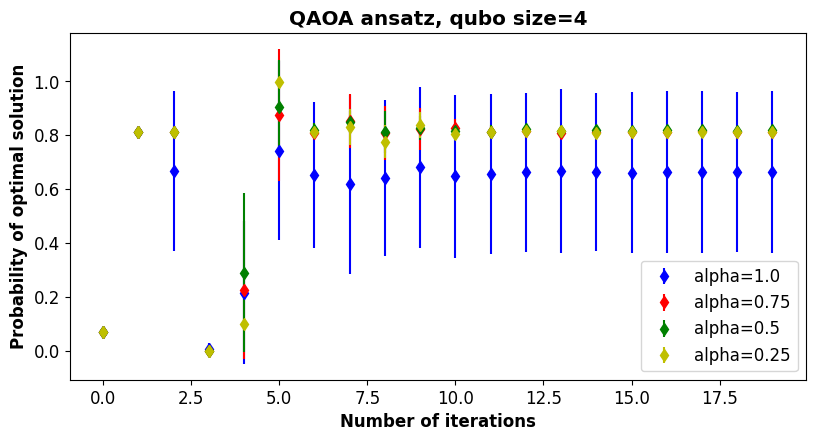

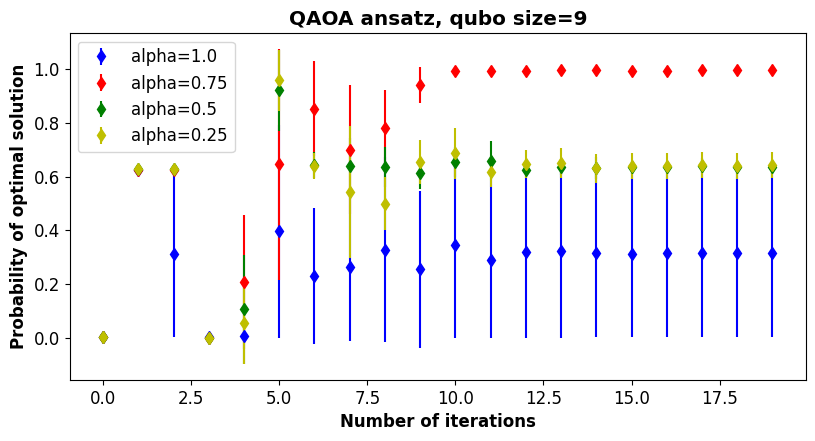

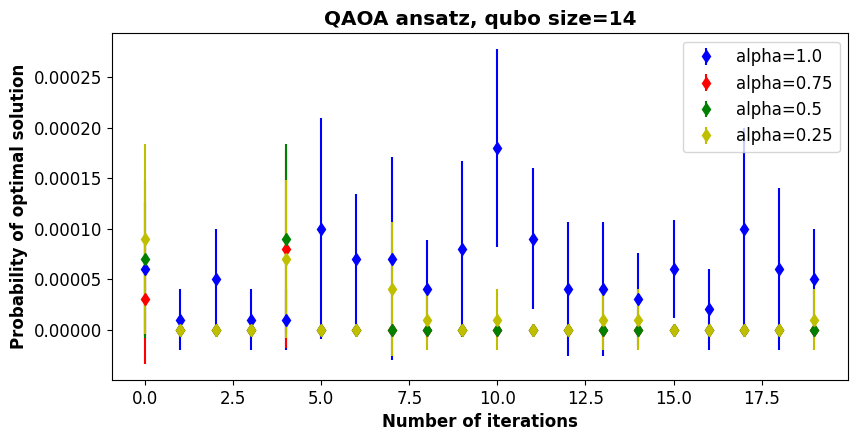

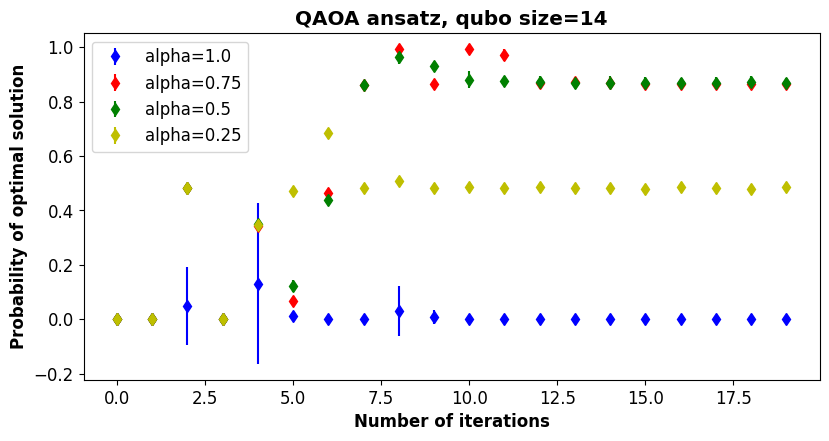

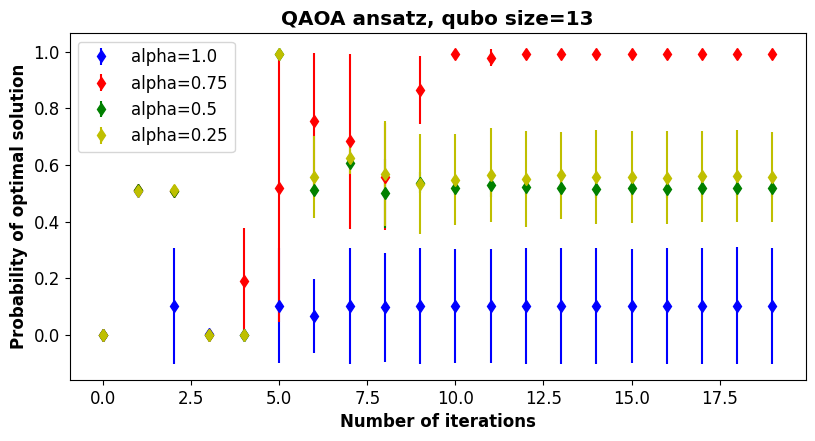

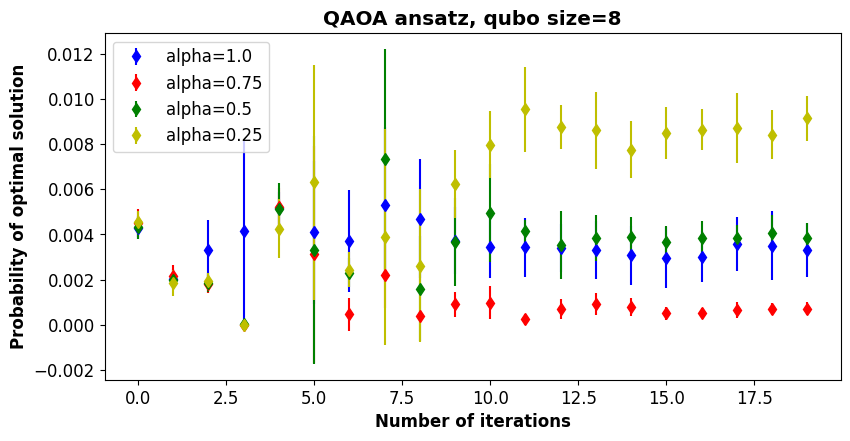

In [25]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.50, 4.50]
plt.rcParams["font.size"] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

c = ['b', 'r', 'g', 'y', 'c']

for slice in range(6):
    plt.figure()
    for i in range(len(alphas)):
        number_of_iterations_qaoa = list(range(len(prob_opt_sol_qaoa_peralpha[i][slice][0])))
        errorbar_qaoa = np.std(prob_opt_sol_qaoa_peralpha[i][slice], axis=0)
        plt.errorbar(number_of_iterations_qaoa, np.mean(prob_opt_sol_qaoa_peralpha[i][slice], axis=0), yerr=errorbar_qaoa, fmt=f'd{c[i]}', label=f'alpha={alphas[i]}')

    plt.legend()
    plt.title(f'QAOA ansatz, qubo size={len(q.qubo_hamiltonian_pairs[slice][0])}')
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Number of iterations')
    plt.ylabel('Probability of optimal solution')


## Comparison of LE ansatz for different values of alpha

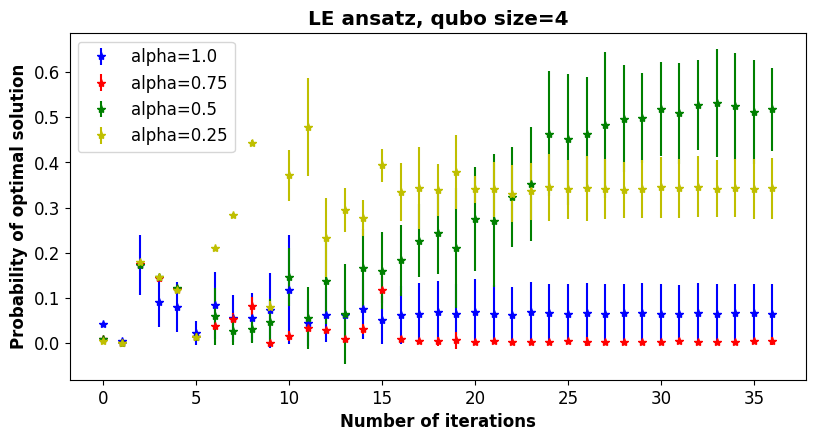

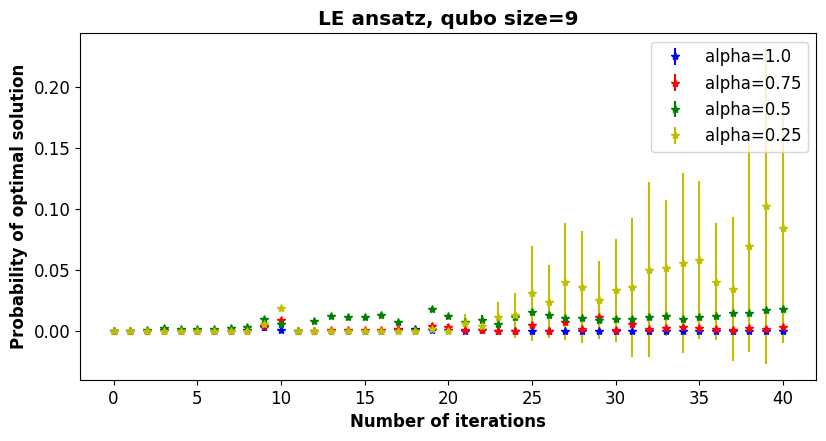

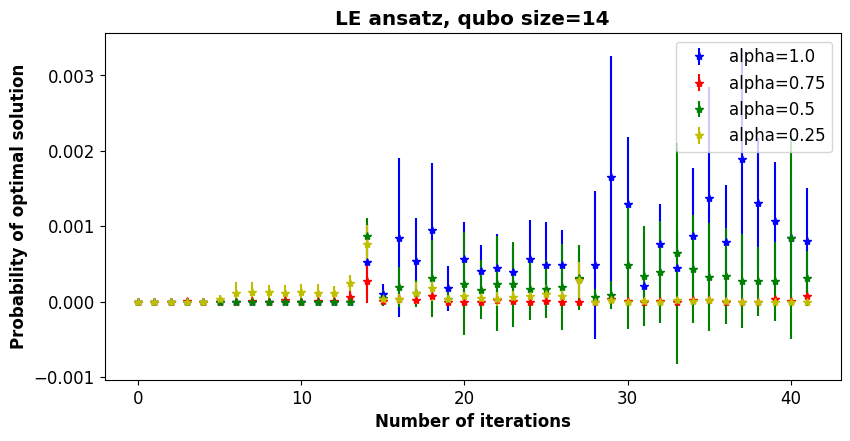

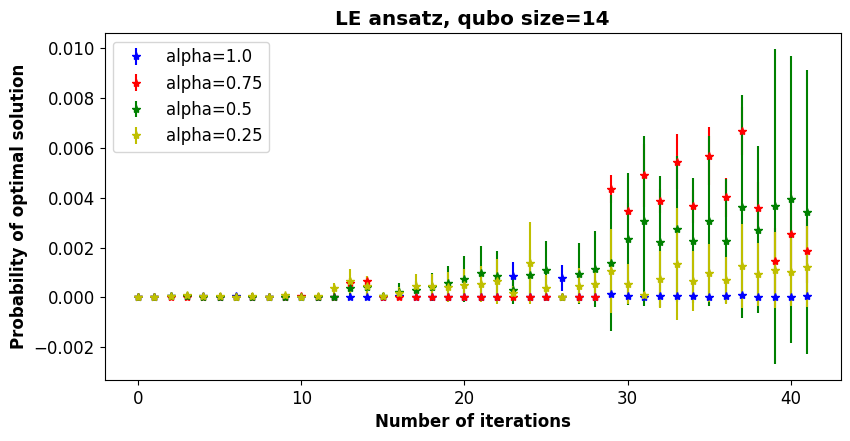

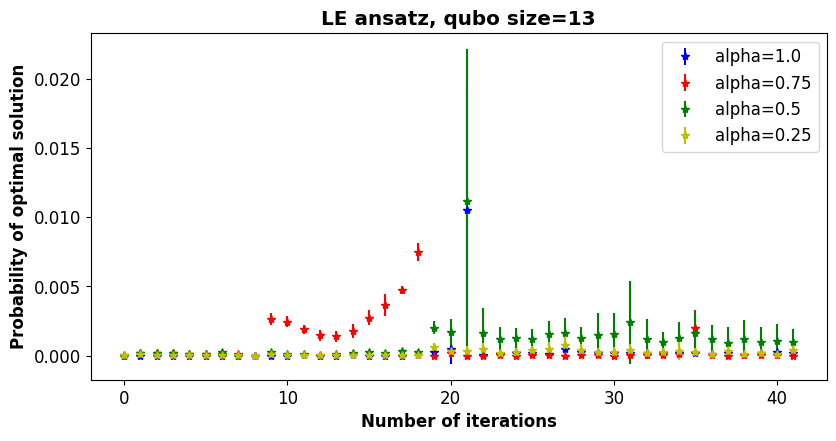

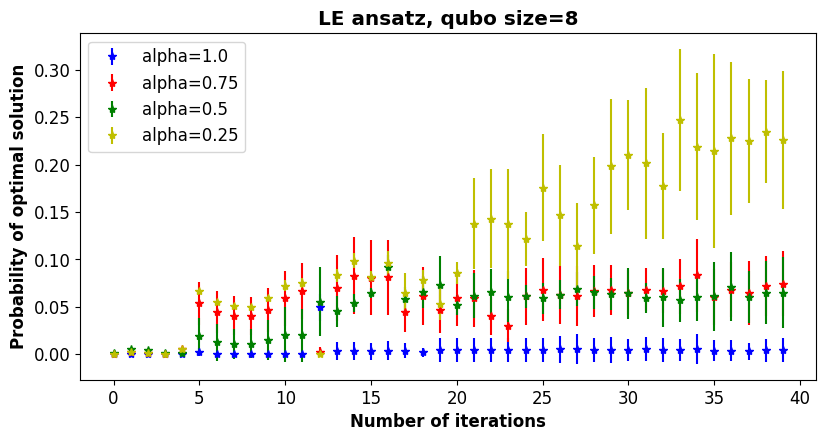

In [26]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.50, 4.50]
plt.rcParams["font.size"] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

c = ['b', 'r', 'g', 'y', 'c']

for slice in range(6):
    plt.figure()
    for i in range(len(alphas)):
        number_of_iterations_linear = list(range(len(prob_opt_sol_linear_peralpha[i][slice][0])))
        errorbar_linear = np.std(prob_opt_sol_linear_peralpha[i][slice], axis=0)
        plt.errorbar(number_of_iterations_linear, np.mean(prob_opt_sol_linear_peralpha[i][slice], axis=0), yerr=errorbar_linear, fmt=f'*{c[i]}', label=f'alpha={alphas[i]}')

    plt.legend()
    plt.title(f'LE ansatz, qubo size={len(q.qubo_hamiltonian_pairs[slice][0])}')
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Number of iterations')
    plt.ylabel('Probability of optimal solution')

## Comparison QAOA and LE ansatz for fixed alpha

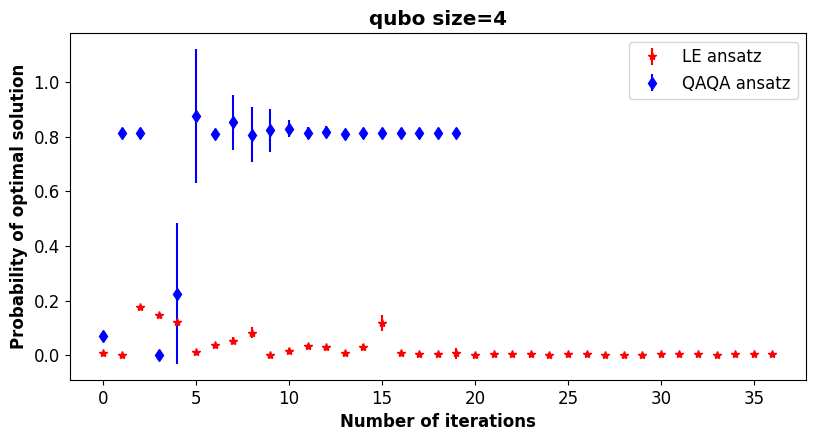

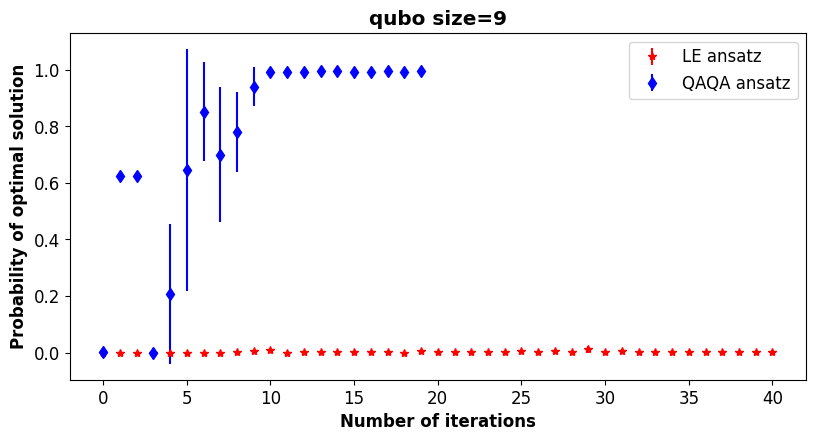

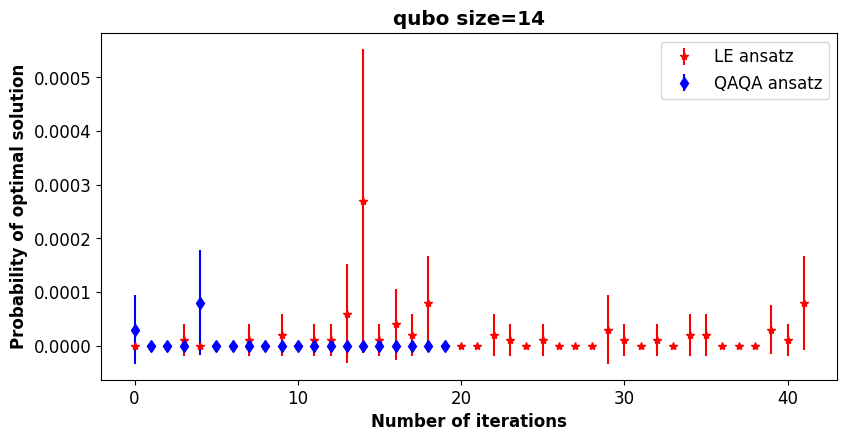

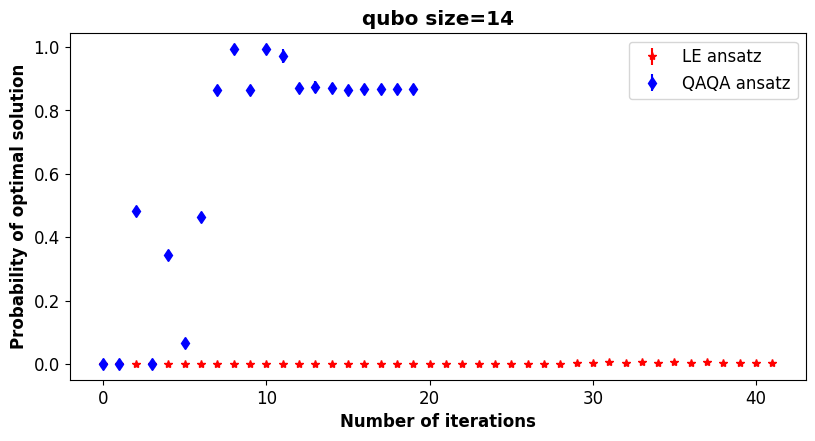

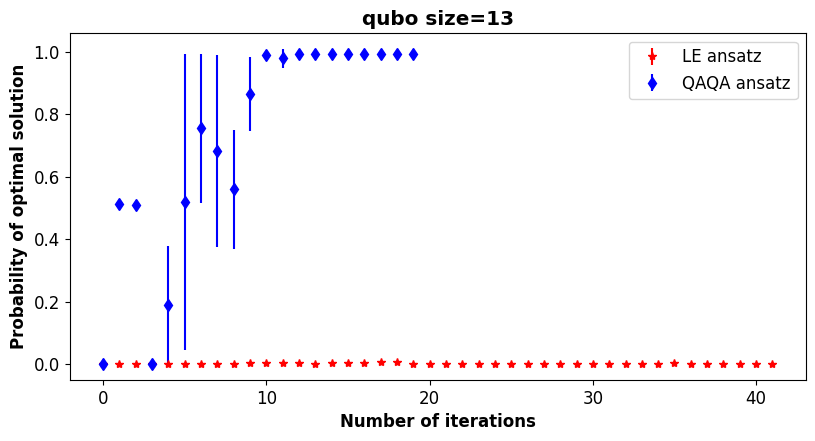

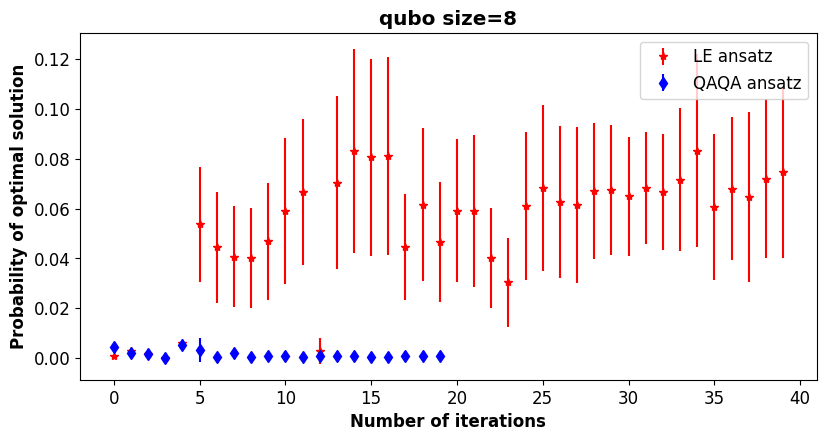

In [27]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.50, 4.50]
plt.rcParams["font.size"] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

for slice in range(6):
    alpha_idx = -3
    number_of_iterations_qaoa = list(range(len(prob_opt_sol_qaoa_peralpha[alpha_idx][slice][0])))
    number_of_iterations_linear = list(range(len(prob_opt_sol_linear_peralpha[alpha_idx][slice][0])))
    errorbar_linear = np.std(prob_opt_sol_linear_peralpha[alpha_idx][slice], axis=0)
    errorbar_qaoa = np.std(prob_opt_sol_qaoa_peralpha[alpha_idx][slice], axis=0)

    plt.figure()
    plt.errorbar(number_of_iterations_linear, np.mean(prob_opt_sol_linear_peralpha[alpha_idx][slice], axis=0), yerr=errorbar_linear, fmt='*r', label='LE ansatz')
    plt.errorbar(number_of_iterations_qaoa, np.mean(prob_opt_sol_qaoa_peralpha[alpha_idx][slice], axis=0), yerr=errorbar_qaoa, fmt='db', label='QAQA ansatz')
    plt.legend()
    plt.title(f'qubo size={len(q.qubo_hamiltonian_pairs[slice][0])}')
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Number of iterations')
    plt.ylabel('Probability of optimal solution')

In [28]:
# extract the probability of optimal solution from the results
cumulative_qaoa_peralpha = []
cumulative_linear_peralpha = []
for k in range(len(alphas)):
    cumulative_qaoa = []

    for slice in range(6):
        L = len(res_qaoa_slices_peralpha[k][slice][0])
        cumulative_perslice = np.zeros((num_mc, L))
        for i in range(num_mc):
            for j in range(len(res_qaoa_slices_peralpha[k][slice][i])): 
                if res_qaoa_slices_peralpha[k][slice][i][j][0] == optimal_solutions[slice][0]:
                    cumulative_perslice[i][j] += res_qaoa_slices_peralpha[k][slice][i][j][1]

        cumulative_qaoa.append(np.cumsum(cumulative_perslice, axis=1)/np.array([1+i for i in range(L)]))

    cumulative_linear = []

    for slice in range(6):
        L = len(res_linear_slices_peralpha[k][slice][0])
        cumulative_perslice = np.zeros((num_mc, L))
        for i in range(num_mc):
            for j in range(len(res_linear_slices_peralpha[k][slice][i])):
                if res_linear_slices_peralpha[k][slice][i][j][0] == optimal_solutions[slice][0]:
                    cumulative_perslice[i][j] += res_linear_slices_peralpha[k][slice][i][j][1]

        cumulative_linear.append(np.cumsum(cumulative_perslice, axis=1)/np.array([1+i for i in range(L)]))
    cumulative_linear_peralpha.append(cumulative_linear)
    cumulative_qaoa_peralpha.append(cumulative_qaoa)

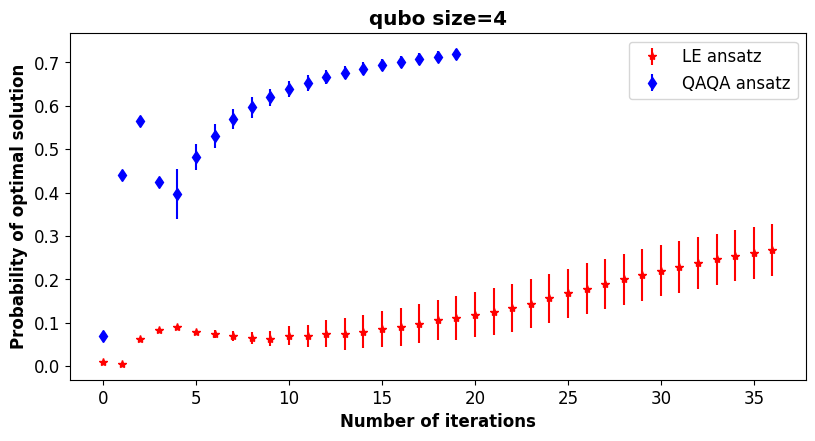

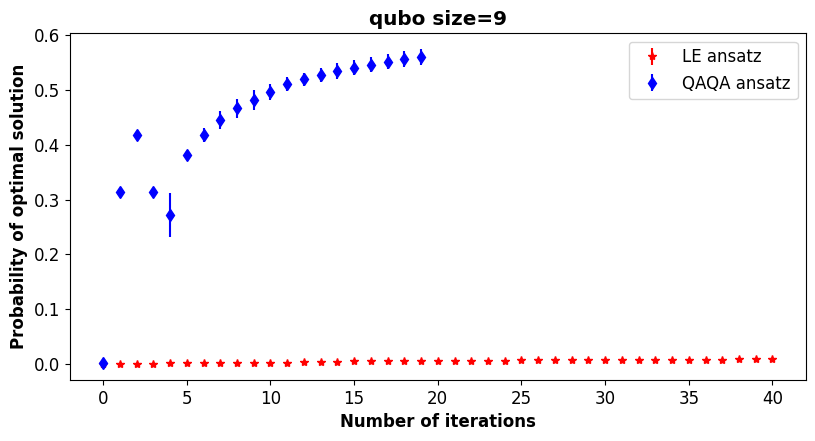

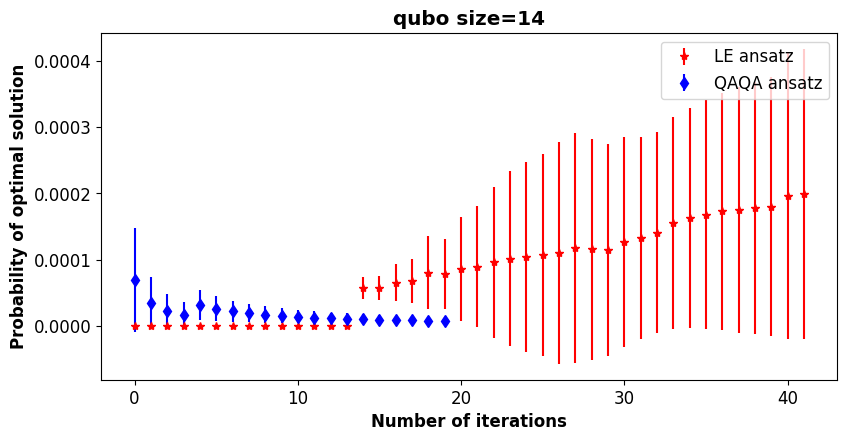

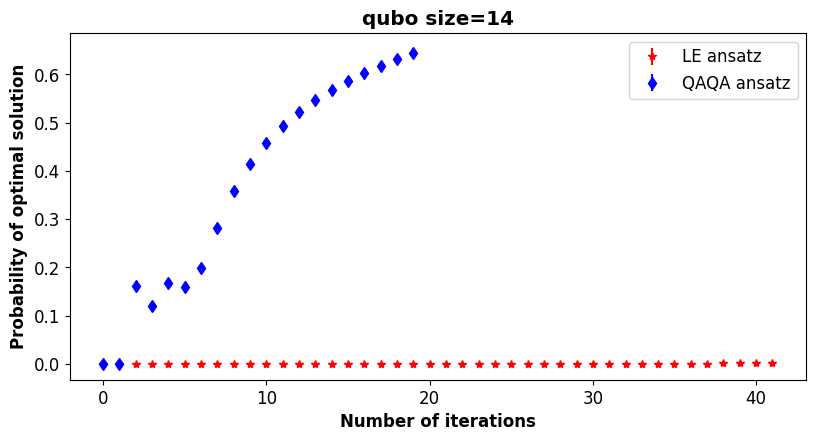

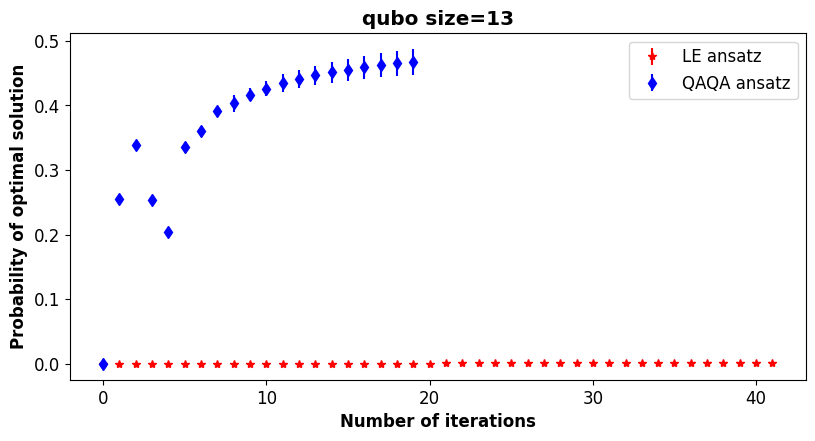

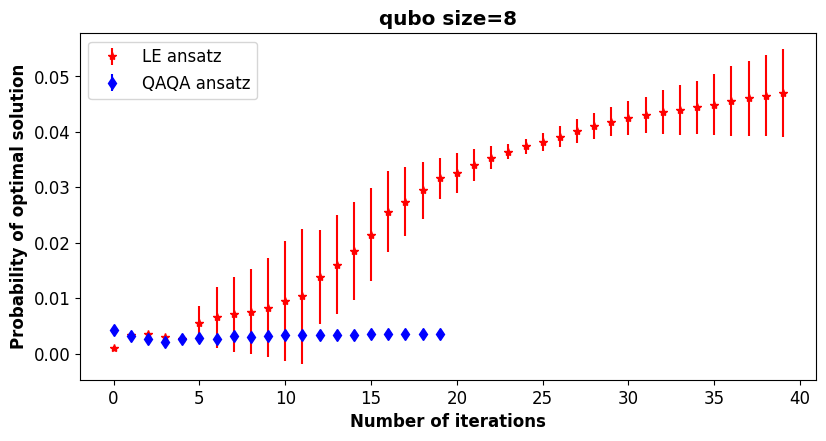

In [29]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.50, 4.50]
plt.rcParams["font.size"] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

for slice in range(6):
    alpha_idx = 2
    number_of_iterations_qaoa = list(range(len(cumulative_qaoa_peralpha[alpha_idx][slice][0])))
    number_of_iterations_linear = list(range(len(cumulative_linear_peralpha[alpha_idx][slice][0])))
    errorbar_linear = np.std(cumulative_linear_peralpha[alpha_idx][slice], axis=0)
    errorbar_qaoa = np.std(cumulative_qaoa_peralpha[alpha_idx][slice], axis=0)

    plt.figure()
    plt.errorbar(number_of_iterations_linear, np.mean(cumulative_linear_peralpha[alpha_idx][slice], axis=0), yerr=errorbar_linear, fmt='*r', label='LE ansatz')
    plt.errorbar(number_of_iterations_qaoa, np.mean(cumulative_qaoa_peralpha[alpha_idx][slice], axis=0), yerr=errorbar_qaoa, fmt='db', label='QAQA ansatz')
    plt.legend()
    plt.title(f'qubo size={len(q.qubo_hamiltonian_pairs[slice][0])}')
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Number of iterations')
    plt.ylabel('Probability of optimal solution')

## Resources required for quantum advantage

In [30]:
resources_qaoa_per_slice = []
resources_linear_per_slice = []

for slice, (qubo, ising_ham) in enumerate(q.qubo_hamiltonian_pairs):
    alpha_idx=2
    num_qubits = len(qubo)

    qaoa_ansatz = QAOAAnsatz(ising_ham, reps=1)
    le_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)
    resources_qaoa, resources_linear = total_gates(qaoa_ansatz), total_gates(le_ansatz)

    iter_factor = (resources_qaoa[1]/resources_linear[1]) * (resources_qaoa[2]/resources_linear[2])
    maxiter_qaoa = maxiter
    maxiter_linear = int(maxiter_qaoa * iter_factor)

    prob_qaoa = np.mean(prob_opt_sol_qaoa_peralpha[alpha_idx][slice], axis=0)[-1]
    prob_linear = np.mean(prob_opt_sol_linear_peralpha[alpha_idx][slice], axis=0)[-1]

    resources_qaoa_per_slice.append({'num_qubits': num_qubits, 'total_gates': resources_qaoa[0], 'depth': resources_qaoa[1], 'num_params': resources_qaoa[2], 'num_iterations': maxiter_qaoa, 'prob optimal solution': prob_qaoa})
    resources_linear_per_slice.append({'num_qubits': num_qubits, 'total_gates': resources_linear[0], 'depth': resources_linear[1], 'num_params': resources_linear[2], 'num_iterations': maxiter_linear, 'prob optimal solution': prob_linear})


In [31]:
import pandas as pd

qaoa_df = pd.DataFrame(resources_qaoa_per_slice)
qaoa_df


,num_qubits,total_gates,depth,num_params,num_iterations,prob optimal solution
0,4,48,38,2,20,0.81975
1,9,243,187,2,20,0.63515
2,14,588,448,2,20,0.00000
3,14,588,448,2,20,0.87023
4,13,507,387,2,20,0.51718
5,8,192,148,2,20,0.00384


In [32]:
linear_df = pd.DataFrame(resources_linear_per_slice)
linear_df

,num_qubits,total_gates,depth,num_params,num_iterations,prob optimal solution
0,4,11,5,8,38,0.51754
1,9,26,10,18,41,0.01782
2,14,41,15,28,42,0.00031
3,14,41,15,28,42,0.00342
4,13,38,14,26,42,0.00101
5,8,23,9,16,41,0.06507


## Probability of eps-optimal solutions
If $E_0$ is the ground energy, we want to consider all the bitstrings with energy $E$ such that $E\leq 0.9\cdot E_0$ if $E_0<0$ and else $E\leq 1.1\cdot E_0$. That is, energies with a relative distance of 0.1 to the optimal energy.

In [38]:
np.random.seed(1)

# now we solve all the qubo's and output optimal bitstrings of for each slice using QAOA and twolocal ansatz
alphas = [1.0, 0.75, 0.5, 0.25]
maxiter = 15
num_mc = 10

res_qaoa_slices_peralpha = []
res_linear_slices_peralpha = []

# If you haved the data from a previous run, set this to true. Else set it to false and it will run and save the data.
saved_data = False

if not saved_data:
    for alpha in alphas:
        print(f'alpha={alpha}')
        res_qaoa_slices = []
        res_linear_slices = []

        i = 0

        for qubo, ising_ham in q.qubo_hamiltonian_pairs:
            num_qubits = len(qubo)

            res_qaoa = []
            res_linear = []
            # print(f"slice {i}")
            i+=1
            
            # define the ansatzes
            # qaoa_ansatz = QAOAAnsatz(ising_ham, reps=1)
            qaoa_ansatz = QAOA_ansatz(qubo=qubo)
            beta  = [0.7977]#, 0.7905]#, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
            gamma = [0.0765]#, 0.1634]#, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
            params_qaoa = np.array(beta+gamma)

            # LE ansatz circuit
            le_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)
            params_linear = np.array([np.random.random()]*le_ansatz.num_parameters)

            # to keep it fair, we want depth * number_of_params * maxiter to be the same for both instances
            resources_qaoa, resources_linear = total_gates(qaoa_ansatz), total_gates(le_ansatz)
            iter_factor = (resources_qaoa[1]/resources_linear[1]) * (resources_qaoa[2]/resources_linear[2])
            maxiter_qaoa = maxiter
            maxiter_linear = int(maxiter_qaoa * iter_factor)

            histories_qaoa = []
            histories_linear = []

            vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, sampler=sampler, params=params_qaoa, prob_opt_sol=False)
            for _ in range(num_mc):
                vqe_qaoa.params = params_qaoa
                vqe_qaoa.history = []

                vqe_qaoa.run(alpha=alpha, maxiter=maxiter_qaoa)
                history = vqe_qaoa.history

                # the following is a hacky way to make sure histories are of same length
                L = len(history)
                last = history[-1]
                for l in range(maxiter_qaoa-L):
                    history.append(last)

                histories_qaoa.append(history)

            vqe_linear = VQE(qubo=qubo, ansatz=le_ansatz, sampler=sampler, params=params_linear, prob_opt_sol=False)
            for _ in range(num_mc):
                vqe_linear.params = params_linear
                vqe_linear.history = []

                vqe_linear.run(alpha=alpha, maxiter=maxiter_linear)
                history = vqe_linear.history

                # the following is a hacky way to make sure histories are of same length
                L = len(history)
                last = history[-1]
                for l in range(maxiter_linear-L):
                    history.append(last)

                histories_linear.append(history)
                
            res_qaoa_slices.append(histories_qaoa)
            res_linear_slices.append(histories_linear)
        res_qaoa_slices_peralpha.append(res_qaoa_slices)
        res_linear_slices_peralpha.append(res_linear_slices)

    with open('qaoa_linear_relative_res_ws.pkl', 'wb') as handle:
            pickle.dump((res_qaoa_slices_peralpha, res_linear_slices_peralpha, alphas), handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else:
    with open(f'qaoa_linear_relative_res_ws.pkl', 'rb') as handle:
        a = pickle.load(handle)
        res_qaoa_slices_peralpha, res_linear_slices_peralpha = a[0], a[1]

alpha=1.0
alpha=0.75
alpha=0.5
alpha=0.25


In [39]:
# extract the probability of optimal solution from the results
prob_opt_sol_qaoa_peralpha = []
prob_opt_sol_linear_peralpha = []
for k in range(len(alphas)):
    prob_opt_sol_qaoa = []

    for slice in range(6):
        probs_perslice = np.zeros((num_mc, len(res_qaoa_slices_peralpha[k][slice][0])))
        for i in range(num_mc):
            for j in range(len(res_qaoa_slices_peralpha[k][slice][i])):
                probs_perslice[i][j] = res_qaoa_slices_peralpha[k][slice][i][j][0]

        prob_opt_sol_qaoa.append(probs_perslice)

    prob_opt_sol_linear = []

    for slice in range(6):
        probs_perslice = np.zeros((num_mc, len(res_linear_slices_peralpha[k][slice][0])))
        for i in range(num_mc):
            for j in range(len(res_linear_slices_peralpha[k][slice][i])):
                probs_perslice[i][j] = res_linear_slices_peralpha[k][slice][i][j][0]

        prob_opt_sol_linear.append(probs_perslice)
    prob_opt_sol_linear_peralpha.append(prob_opt_sol_linear)
    prob_opt_sol_qaoa_peralpha.append(prob_opt_sol_qaoa)

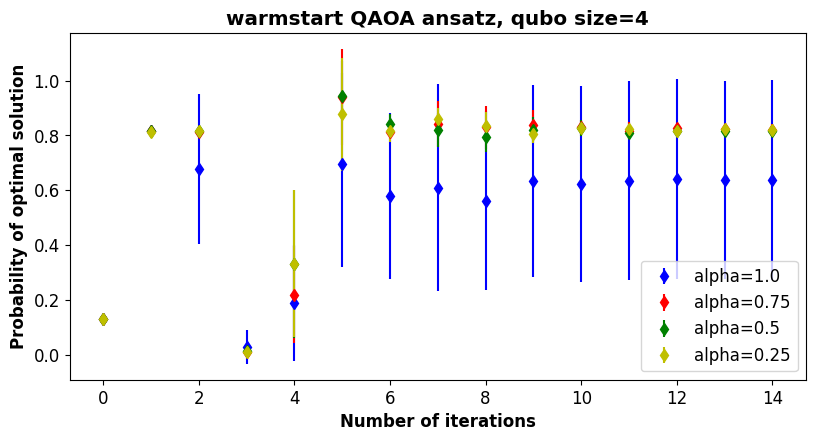

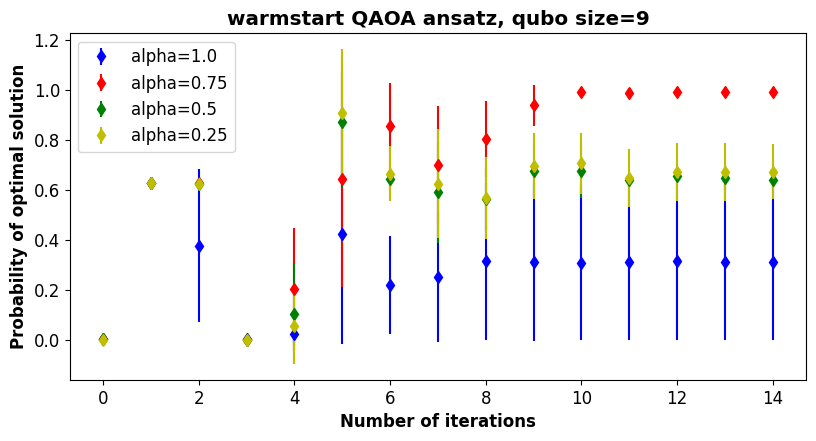

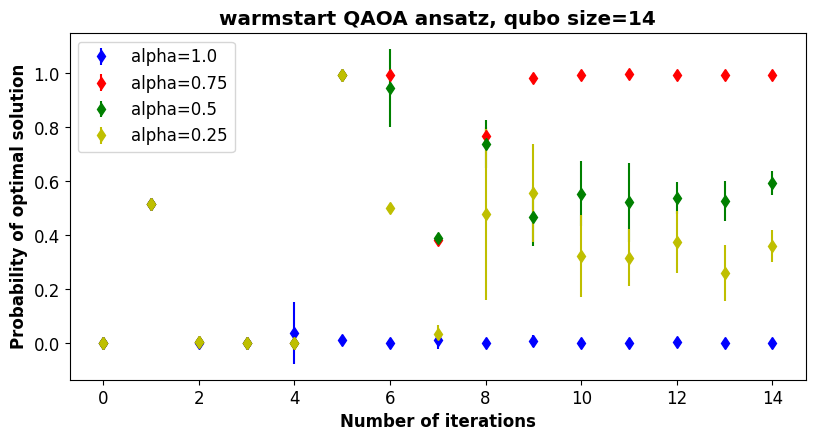

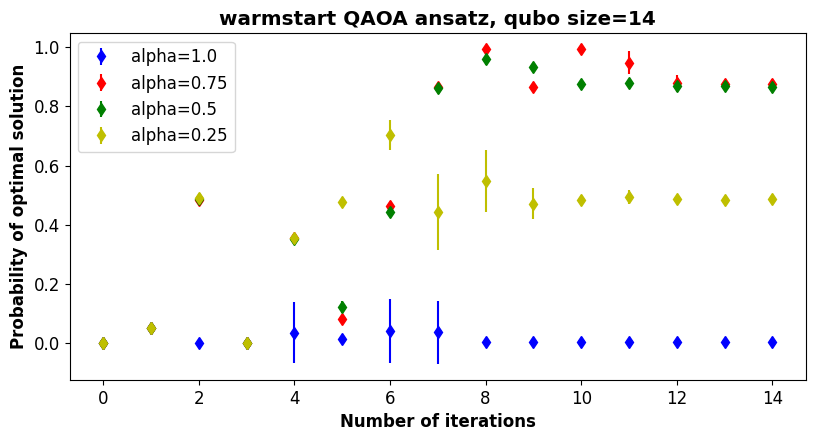

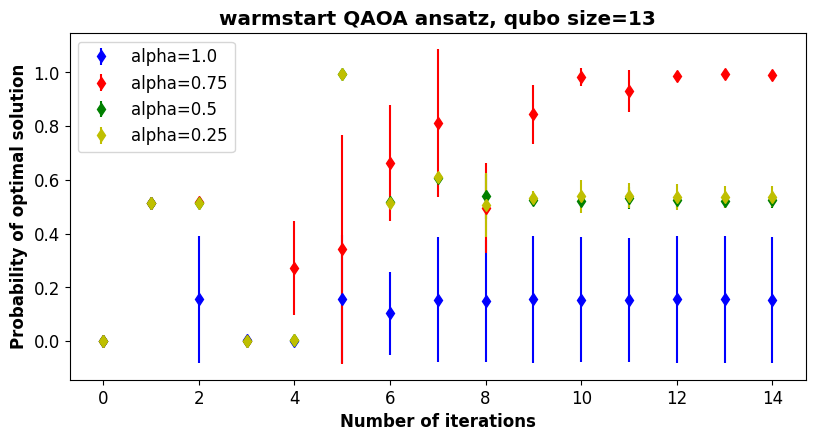

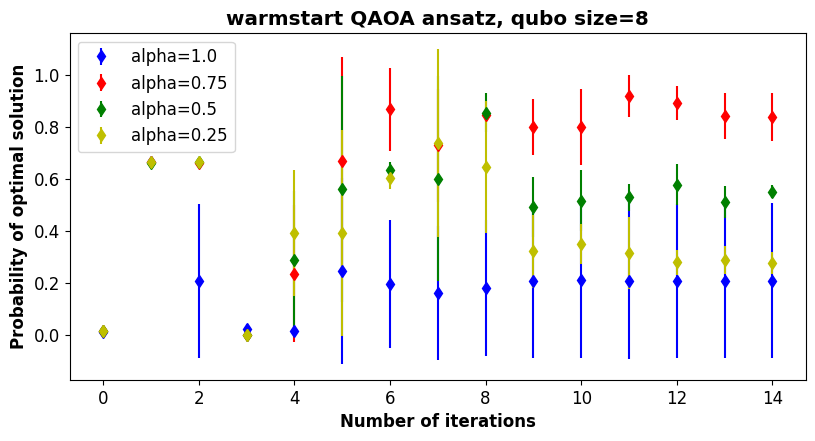

In [40]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.50, 4.50]
plt.rcParams["font.size"] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

c = ['b', 'r', 'g', 'y', 'c']

for slice in range(6):
    plt.figure()
    for i in range(len(alphas)):
        number_of_iterations_qaoa = list(range(len(prob_opt_sol_qaoa_peralpha[i][slice][0])))
        errorbar_qaoa = np.std(prob_opt_sol_qaoa_peralpha[i][slice], axis=0)
        plt.errorbar(number_of_iterations_qaoa, np.mean(prob_opt_sol_qaoa_peralpha[i][slice], axis=0), yerr=errorbar_qaoa, fmt=f'd{c[i]}', label=f'alpha={alphas[i]}')

    plt.legend()
    plt.title(f'warmstart QAOA ansatz, qubo size={len(q.qubo_hamiltonian_pairs[slice][0])}')
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Number of iterations')
    plt.ylabel('Probability of optimal solution')


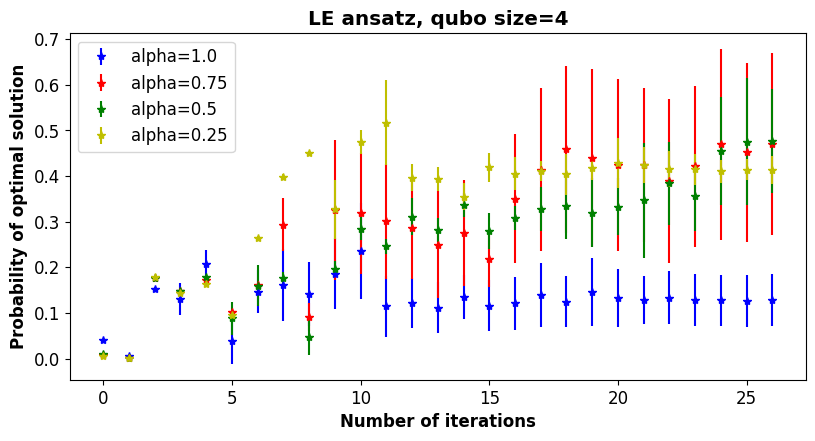

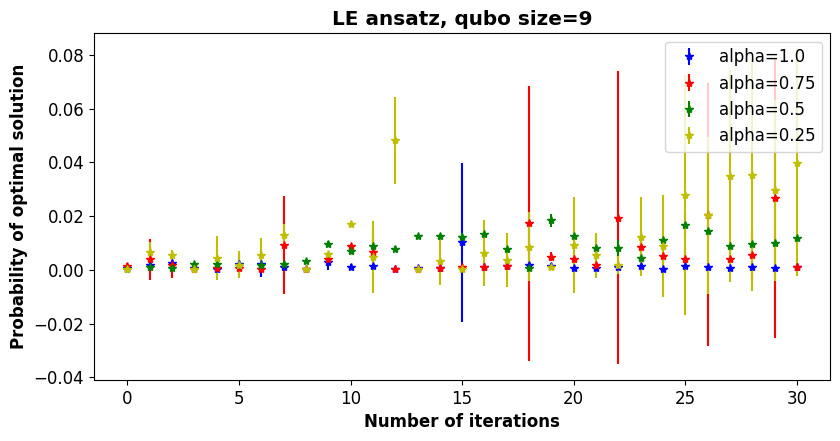

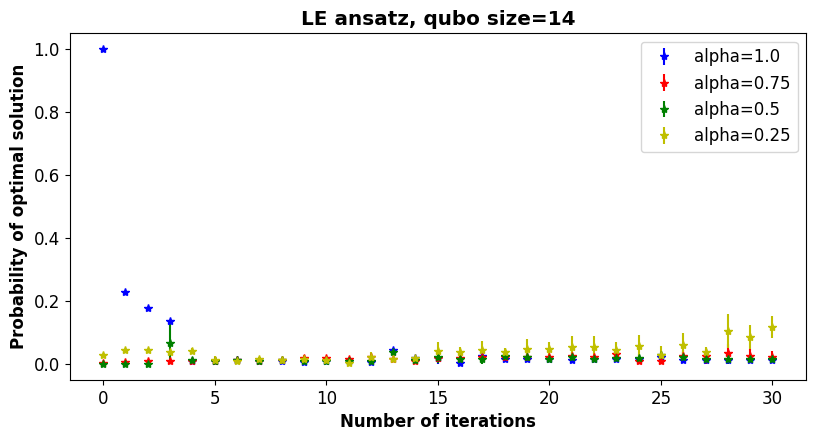

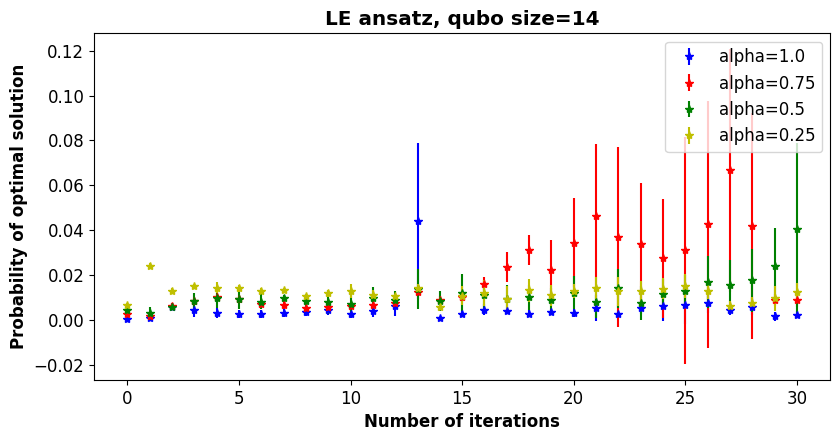

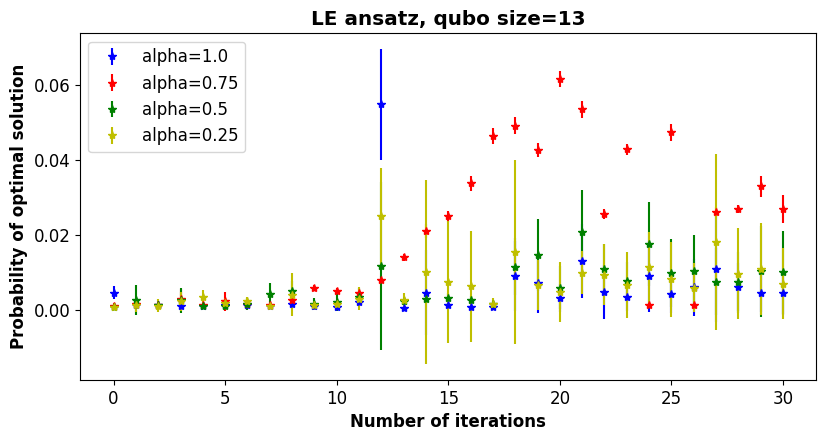

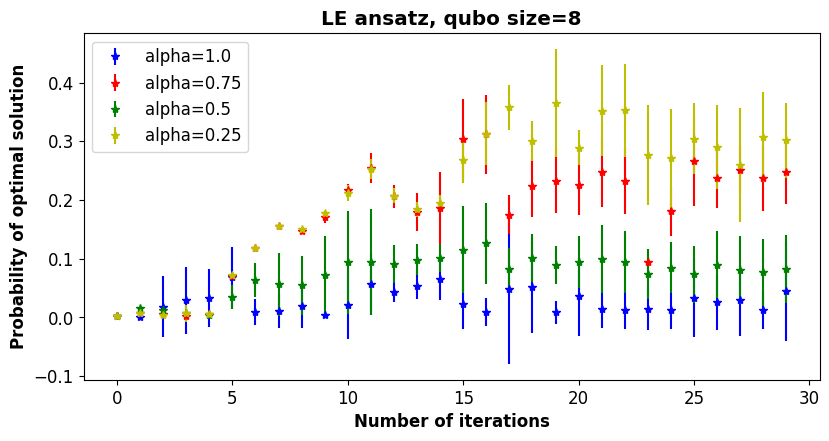

In [41]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.50, 4.50]
plt.rcParams["font.size"] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

c = ['b', 'r', 'g', 'y', 'c']

for slice in range(6):
    plt.figure()
    for i in range(len(alphas)):
        number_of_iterations_linear = list(range(len(prob_opt_sol_linear_peralpha[i][slice][0])))
        errorbar_linear = np.std(prob_opt_sol_linear_peralpha[i][slice], axis=0)
        plt.errorbar(number_of_iterations_linear, np.mean(prob_opt_sol_linear_peralpha[i][slice], axis=0), yerr=errorbar_linear, fmt=f'*{c[i]}', label=f'alpha={alphas[i]}')

    plt.legend()
    plt.title(f'LE ansatz, qubo size={len(q.qubo_hamiltonian_pairs[slice][0])}')
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Number of iterations')
    plt.ylabel('Probability of optimal solution')

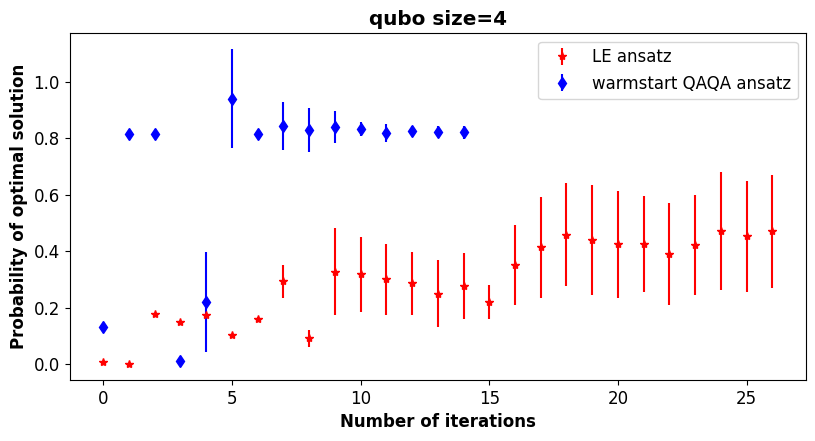

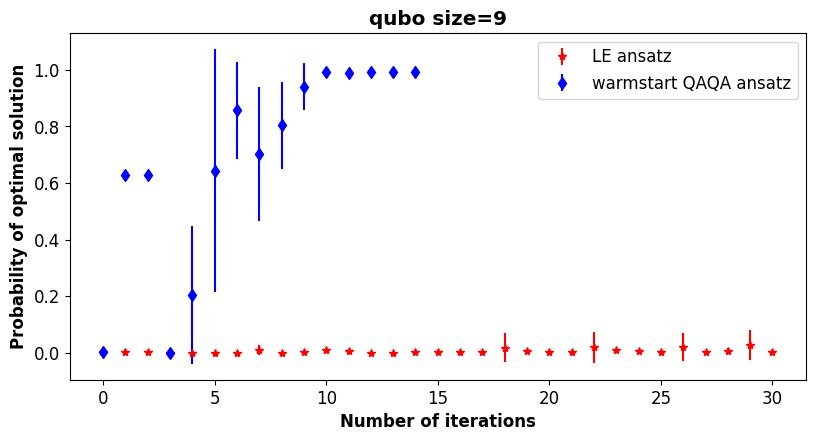

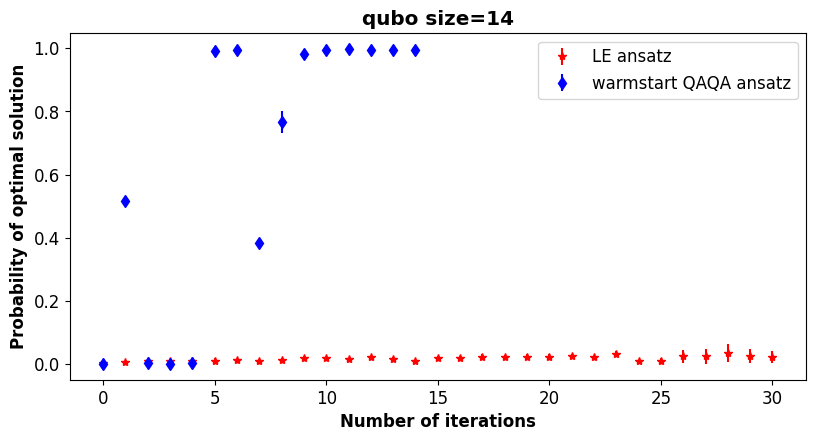

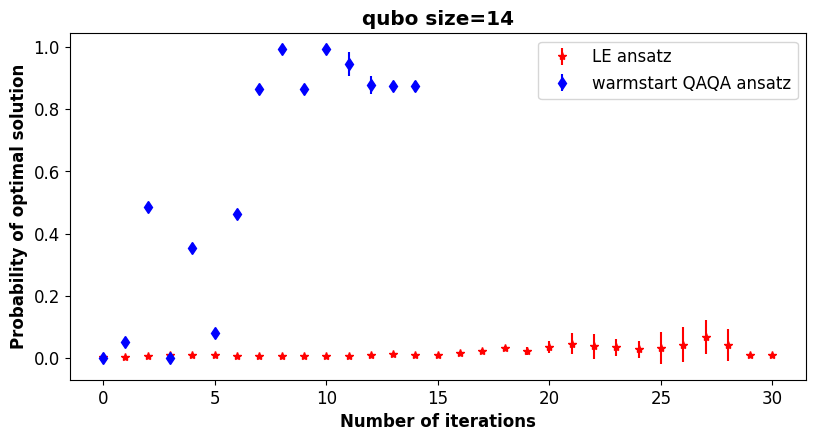

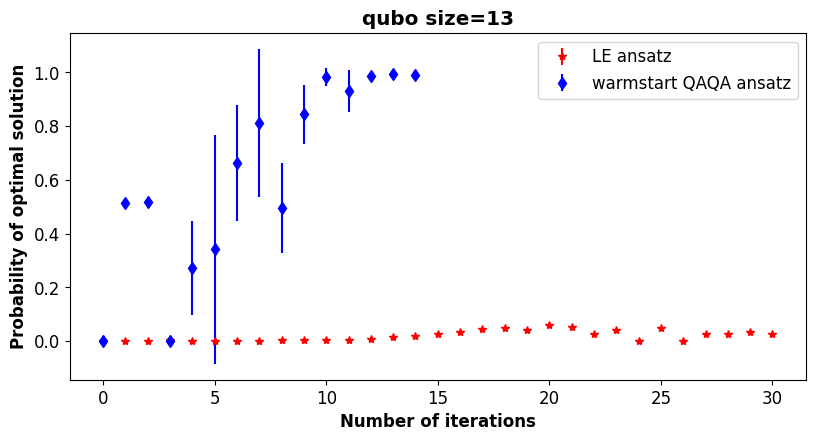

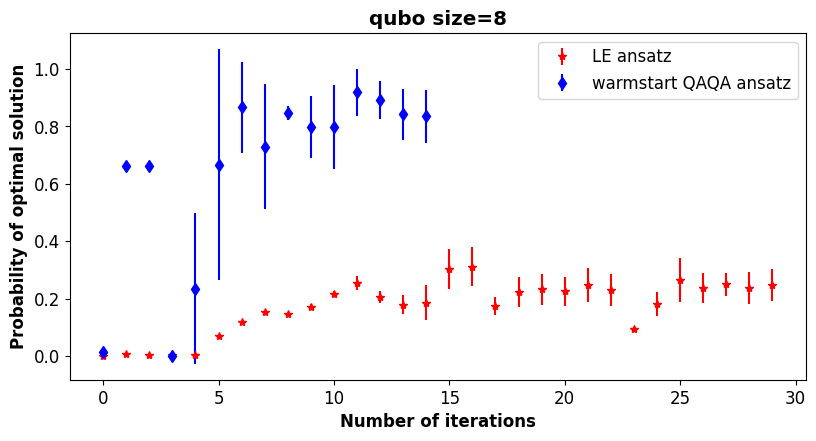

In [42]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.50, 4.50]
plt.rcParams["font.size"] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

for slice in range(6):
    alpha_idx = -3
    number_of_iterations_qaoa = list(range(len(prob_opt_sol_qaoa_peralpha[alpha_idx][slice][0])))
    number_of_iterations_linear = list(range(len(prob_opt_sol_linear_peralpha[alpha_idx][slice][0])))
    errorbar_linear = np.std(prob_opt_sol_linear_peralpha[alpha_idx][slice], axis=0)
    errorbar_qaoa = np.std(prob_opt_sol_qaoa_peralpha[alpha_idx][slice], axis=0)

    plt.figure()
    plt.errorbar(number_of_iterations_linear, np.mean(prob_opt_sol_linear_peralpha[alpha_idx][slice], axis=0), yerr=errorbar_linear, fmt='*r', label='LE ansatz')
    plt.errorbar(number_of_iterations_qaoa, np.mean(prob_opt_sol_qaoa_peralpha[alpha_idx][slice], axis=0), yerr=errorbar_qaoa, fmt='db', label='warmstart QAQA ansatz')
    plt.legend()
    plt.title(f'qubo size={len(q.qubo_hamiltonian_pairs[slice][0])}')
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Number of iterations')
    plt.ylabel('Probability of optimal solution')

In [43]:
resources_qaoa_per_slice = []
resources_linear_per_slice = []

for slice, (qubo, ising_ham) in enumerate(q.qubo_hamiltonian_pairs):
    alpha_idx=2
    num_qubits = len(qubo)

    qaoa_ansatz = QAOA_ansatz(qubo=qubo)
    le_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)
    resources_qaoa, resources_linear = total_gates(qaoa_ansatz), total_gates(le_ansatz)

    iter_factor = (resources_qaoa[1]/resources_linear[1]) * (resources_qaoa[2]/resources_linear[2])
    maxiter_qaoa = maxiter
    maxiter_linear = int(maxiter_qaoa * iter_factor)

    prob_qaoa = np.mean(prob_opt_sol_qaoa_peralpha[alpha_idx][slice], axis=0)[-1]
    prob_linear = np.mean(prob_opt_sol_linear_peralpha[alpha_idx][slice], axis=0)[-1]

    resources_qaoa_per_slice.append({'num_qubits': num_qubits, 'total_gates': resources_qaoa[0], 'depth': resources_qaoa[1], 'num_params': resources_qaoa[2], 'num_iterations': maxiter_qaoa, 'prob optimal solution': prob_qaoa})
    resources_linear_per_slice.append({'num_qubits': num_qubits, 'total_gates': resources_linear[0], 'depth': resources_linear[1], 'num_params': resources_linear[2], 'num_iterations': maxiter_linear, 'prob optimal solution': prob_linear})


In [46]:
wsqaoa_df = pd.DataFrame(resources_qaoa_per_slice)
wsqaoa_df

,num_qubits,total_gates,depth,num_params,num_iterations,prob optimal solution
0,4,45,37,2,15,0.81546
1,9,236,187,2,15,0.64003
2,14,576,447,2,15,0.59516
3,14,577,447,2,15,0.86501
4,13,496,386,2,15,0.52692
5,8,186,147,2,15,0.55053


In [45]:
linear_df = pd.DataFrame(resources_linear_per_slice)
linear_df

,num_qubits,total_gates,depth,num_params,num_iterations,prob optimal solution
0,4,11,5,8,27,0.47723
1,9,26,10,18,31,0.01184
2,14,41,15,28,31,0.01530
3,14,41,15,28,31,0.04053
4,13,38,14,26,31,0.00997
5,8,23,9,16,30,0.08269


## Number of physical qubits required

## Benchmarking wsQAOA on random Gaussian mixtures

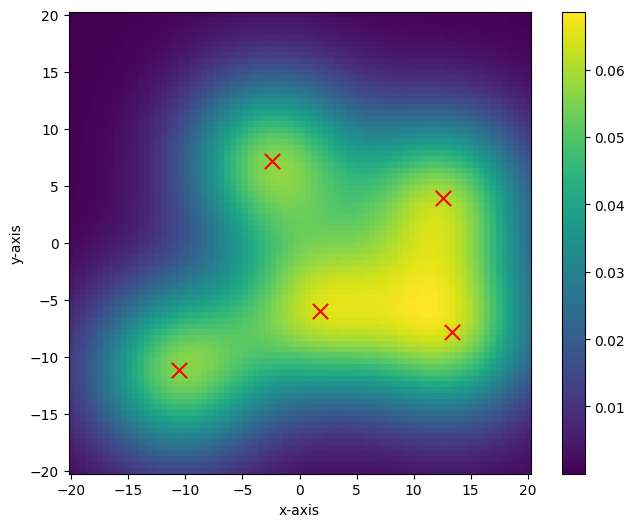

In [1]:
from aquapointer.density_canvas.DensityCanvas import DensityCanvas

# define a canvas
origin = (-20, -20)
length = 40
npoints = 80
canvas = DensityCanvas(
    origin=origin,
    length_x=length,
    length_y=length,
    npoints_x=npoints,
    npoints_y=npoints,
)

# extract random centers with a minimal distance
# and a padding from border
seed = 18389
n_centers = 5 #number of Gaussians
min_dist = 10 #minimal distance between gaussians
padding = 6 #minimal distance of Gaussian centers from border
amplitude = 10 #amplitude of the Gaussians
variance = 30 #variance of the Gaussians

canvas.set_randomized_gaussian_density(
    n_centers = n_centers,
    amplitude = amplitude,
    variance = variance,
    minimal_distance = min_dist,
    padding = padding,
    seed = seed
)

# To see the result, call the draw method with draw_centers=True
canvas.draw(draw_centers=True, figsize=(8,6))

In [2]:
# from aquapointer.digital.loaddata import LoadData
from aquapointer.digital.qubo import Qubo
from aquapointer.digital.vqe import VQE
from aquapointer.digital.ansatz import QAOA_ansatz

# General imports
import numpy as np
import pickle

# Pre-defined ansatz circuit, operator class
from qiskit.primitives import BackendSampler
from qiskit import QuantumCircuit, transpile 
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer import AerSimulator

backend = AerSimulator()
sampler = BackendSampler(backend=backend, options={"shots": int(1e4)})

def get_qubo_coeffs(canvas):
    estimated_variance = 30
    estimated_amplitude = 10

    canvas.set_poisson_disk_lattice(spacing=(5, 5))
    _ = canvas.calculate_pubo_coefficients(
            p = 2, #order of the PUBO, p=2 effectively creates a QUBO
            params = [estimated_amplitude, estimated_variance],
            efficient_qubo=True
        )
    canvas.force_lattice_size(7)
    # canvas.draw(draw_lattice=True)
    rescaled_positions = canvas._lattice._coords
    qubo_coeffs = canvas._pubo

    return qubo_coeffs

In [3]:
qubo = get_qubo_coeffs(canvas)

In [4]:
# from the qubo coefficients dictionary, create a qubo matrix:
def get_random_qubo(seed):

    # extract random centers with a minimal distance
    # and a padding from border
    n_centers = 5 #number of Gaussians
    min_dist = 10 #minimal distance between gaussians
    padding = 6 #minimal distance of Gaussian centers from border
    amplitude = 10 #amplitude of the Gaussians
    variance = 30 #variance of the Gaussians

    canvas.set_randomized_gaussian_density(
        n_centers = n_centers,
        amplitude = amplitude,
        variance = variance,
        minimal_distance = min_dist,
        padding = padding,
        seed = seed
    )

    qubo = get_qubo_coeffs(canvas)
    
    qubo_matrix = np.zeros((len(qubo['coeffs'][1]), len(qubo['coeffs'][1])))

    for key in qubo['coeffs'][1].keys():
        qubo_matrix[key[0]][key[0]] = qubo['coeffs'][1][key]

    for key in qubo['coeffs'][2].keys():
        qubo_matrix[key] = qubo['coeffs'][2][key]
        qubo_matrix[key[::-1]] = qubo['coeffs'][2][key]

    return qubo_matrix

In [5]:
qubo_matrix = get_random_qubo(seed = 18389)

In [6]:
qaoa_ansatz = QAOA_ansatz(qubo=qubo_matrix)
beta  = [np.pi/5]#[0.7977]#, 0.7905]#, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [np.pi/5]#[0.0765]#, 0.1634]#, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
params_qaoa = np.array(beta+gamma)

vqe_qaoa = VQE(qubo=qubo_matrix, ansatz=qaoa_ansatz, sampler=sampler, params=params_qaoa, prob_opt_sol=True)

vqe_qaoa.run(alpha=0.95, maxiter=15)

vqe_qaoa.history

[['1100000', 0.0002, -1.1704860738609533],
 ['1100000', 0.9755, -1.1704860738609533],
 ['1100000', 0.9779, -1.1704860738609533],
 ['1001001', 0.0016, -1.1387275013073392],
 ['1100000', 0.0972, -1.1704860738609533],
 ['1100000', 0.7676, -1.1704860738609533],
 ['1100000', 0.9765, -1.1704860738609533],
 ['1100000', 0.505, -1.1704860738609533],
 ['1100000', 0.7939, -1.1704860738609533],
 ['1100000', 1.0, -1.1704860738609533],
 ['1100000', 0.9767, -1.1704860738609533],
 ['1100000', 0.9836, -1.1704860738609533],
 ['1100000', 0.976, -1.1704860738609533],
 ['1100000', 0.977, -1.1704860738609533],
 ['1100000', 0.9785, -1.1704860738609533]]

In [7]:
# classical brute-force solution
from aquapointer.digital.qubo_utils import find_optimum, get_ising_hamiltonian
solution = find_optimum(qubo=qubo_matrix)
solution

('1100000', -1.1704860738609533)

In [8]:
qaoa_ansatz = QAOAAnsatz(get_ising_hamiltonian(qubo_matrix), reps=1)
beta  = [np.pi/5]#[0.7977]#, 0.7905]#, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [np.pi/5]#[0.0765]#, 0.1634]#, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
params_qaoa = np.array(beta+gamma)

vqe_qaoa = VQE(qubo=qubo_matrix, ansatz=qaoa_ansatz, sampler=sampler, params=params_qaoa, prob_opt_sol=True)

vqe_qaoa.run(alpha=0.95, maxiter=15)

vqe_qaoa.history

[['1100000', 0.0005, -1.1704860738609533],
 ['1100000', 0.9753, -1.1704860738609533],
 ['1100000', 0.9782, -1.1704860738609533],
 ['1100000', 0.0001, -1.1704860738609533],
 ['1100000', 0.1071, -1.1704860738609533],
 ['1100000', 0.7688, -1.1704860738609533],
 ['1100000', 0.9766, -1.1704860738609533],
 ['1100000', 0.5118, -1.1704860738609533],
 ['1100000', 0.7913, -1.1704860738609533],
 ['1100000', 0.9998, -1.1704860738609533],
 ['1100000', 0.9733, -1.1704860738609533],
 ['1100000', 0.9832, -1.1704860738609533],
 ['1100000', 0.9775, -1.1704860738609533],
 ['1100000', 0.9807, -1.1704860738609533],
 ['1100000', 0.9784, -1.1704860738609533]]

In [46]:
np.random.seed(1)

# now we solve all the qubo's and output optimal bitstrings of for each slice using QAOA and twolocal ansatz
alphas = [0.95, 0.75, 0.5, 0.25]
maxiter = 15
num_mc = 30

res_wsqaoa_seeds_peralpha = []
res_qaoa_seeds_peralpha = []

# If you haved the data from a previous run, set this to true. Else set it to false and it will run and save the data.
saved_data = False

if not saved_data:
    for alpha in alphas:
        print(f'alpha={alpha}')
        res_wsqaoa_seeds = []
        res_qaoa_seeds= []

        i = 0
        for seed in range(5):
            # get a random qubo problem here
            qubo = get_random_qubo(seed = seed)

            num_qubits = len(qubo)

            res_wsqaoa = []
            res_qaoa = []
            # print(f"slice {i}")
            i+=1
            
            # define the ansatzes
            wsqaoa_ansatz = QAOA_ansatz(qubo=qubo_matrix)
            beta  = [np.pi/5]#[0.7977]#, 0.7905]#, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
            gamma = [np.pi/5]#[0.0765]#, 0.1634]#, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
            params_wsqaoa = np.array(beta+gamma)

            qaoa_ansatz = QAOAAnsatz(get_ising_hamiltonian(qubo_matrix), reps=1)
            beta  = [np.pi/5]#[0.7977]#, 0.7905]#, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
            gamma = [np.pi/5]#[0.0765]#, 0.1634]#, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
            params_qaoa = np.array(beta+gamma)

            
            histories_wsqaoa = []
            histories_qaoa = []

            vqe_wsqaoa = VQE(qubo=qubo, ansatz=wsqaoa_ansatz, sampler=sampler, params=params_wsqaoa, prob_opt_sol=False)

            vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, sampler=sampler, params=params_wsqaoa, prob_opt_sol=False)

            for _ in range(num_mc):
                vqe_wsqaoa.params = params_wsqaoa
                vqe_wsqaoa.history = []

                vqe_wsqaoa.run(alpha=alpha, maxiter=maxiter)
                history = vqe_wsqaoa.history

                # the following is a hacky way to make sure histories are of same length
                L = len(history)
                last = history[-1]
                for l in range(maxiter-L):
                    history.append(last)

                histories_wsqaoa.append(history)

            for _ in range(num_mc):
                vqe_qaoa.params = params_qaoa
                vqe_qaoa.history = []

                vqe_qaoa.run(alpha=alpha, maxiter=maxiter)
                history = vqe_qaoa.history

                # the following is a hacky way to make sure histories are of same length
                L = len(history)
                last = history[-1]
                for l in range(maxiter-L):
                    history.append(last)

                histories_qaoa.append(history)
                
            res_wsqaoa_seeds.append(histories_wsqaoa)
            res_qaoa_seeds.append(histories_qaoa)
        res_wsqaoa_seeds_peralpha.append(res_wsqaoa_seeds)
        res_qaoa_seeds_peralpha.append(res_qaoa_seeds)

    with open('wsqaoa_qaoa_relative_res.pkl', 'wb') as handle:
            pickle.dump((res_wsqaoa_seeds_peralpha, res_qaoa_seeds_peralpha, alphas), handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else:
    with open(f'qaoa_linear_relative_res_ws.pkl', 'rb') as handle:
        a = pickle.load(handle)
        res_qaoa_slices_peralpha, res_linear_slices_peralpha = a[0], a[1]

alpha=0.95
alpha=0.75
alpha=0.5
alpha=0.25


In [47]:
# extract the probability of optimal solution from the results
prob_opt_sol_wsqaoa_peralpha = []
prob_opt_sol_qaoa_peralpha = []
for k in range(len(alphas)):
    prob_opt_sol_wsqaoa = []

    for seed in range(5):
        probs_perseed = np.zeros((num_mc, len(res_wsqaoa_seeds_peralpha[k][seed][0])))
        for i in range(num_mc):
            for j in range(len(res_wsqaoa_seeds_peralpha[k][seed][i])):
                probs_perseed[i][j] = res_wsqaoa_seeds_peralpha[k][seed][i][j][0] #0 if prob_opt_sol=False

        prob_opt_sol_wsqaoa.append(probs_perseed)

    prob_opt_sol_qaoa = []

    for slice in range(5):
        probs_perseed = np.zeros((num_mc, len(res_qaoa_seeds_peralpha[k][seed][0])))
        for i in range(num_mc):
            for j in range(len(res_qaoa_seeds_peralpha[k][seed][i])):
                probs_perseed[i][j] = res_qaoa_seeds_peralpha[k][seed][i][j][0] #0 if prob_opt_sol=False

        prob_opt_sol_qaoa.append(probs_perseed)
    prob_opt_sol_wsqaoa_peralpha.append(prob_opt_sol_wsqaoa)
    prob_opt_sol_qaoa_peralpha.append(prob_opt_sol_qaoa)

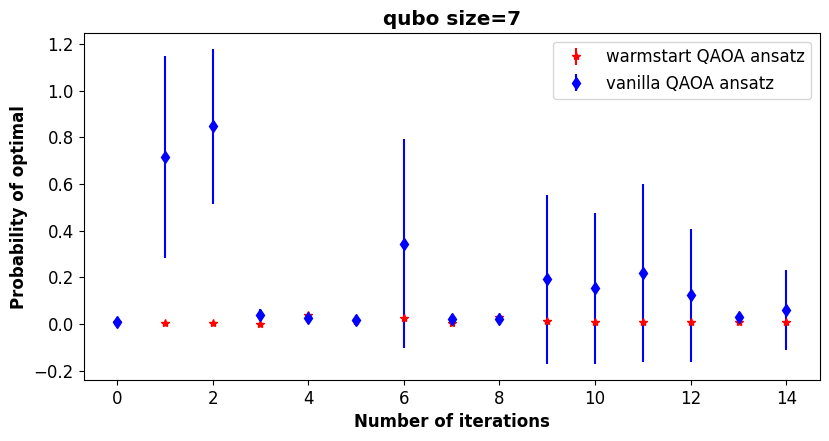

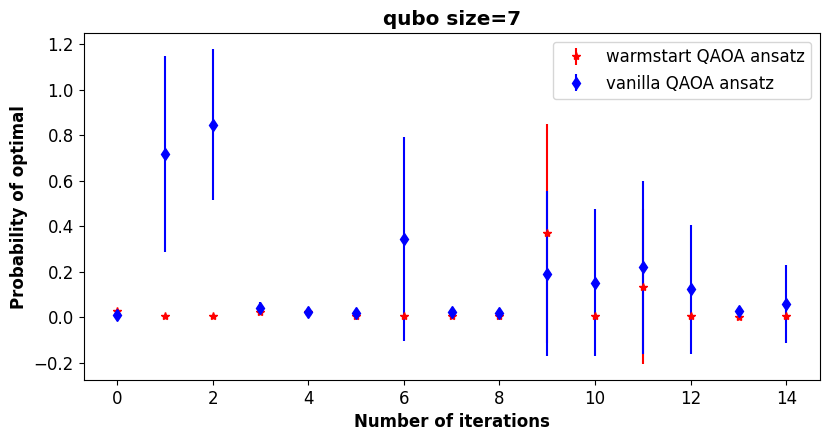

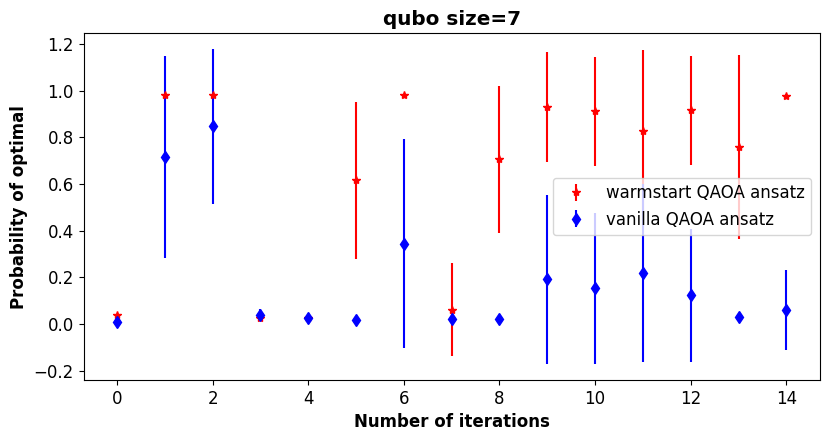

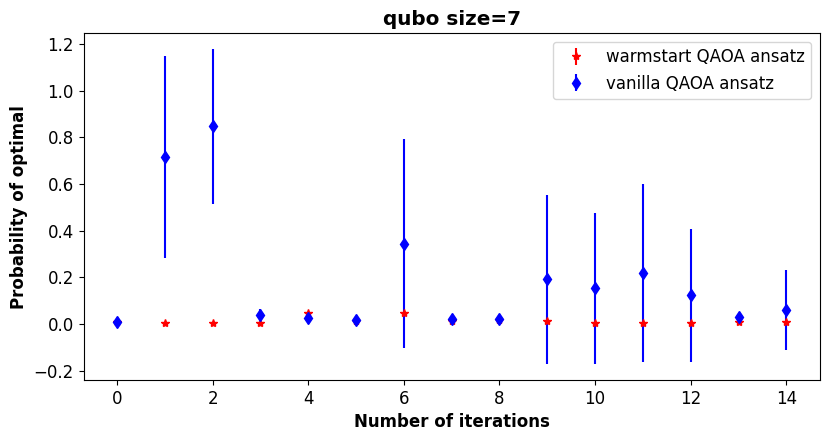

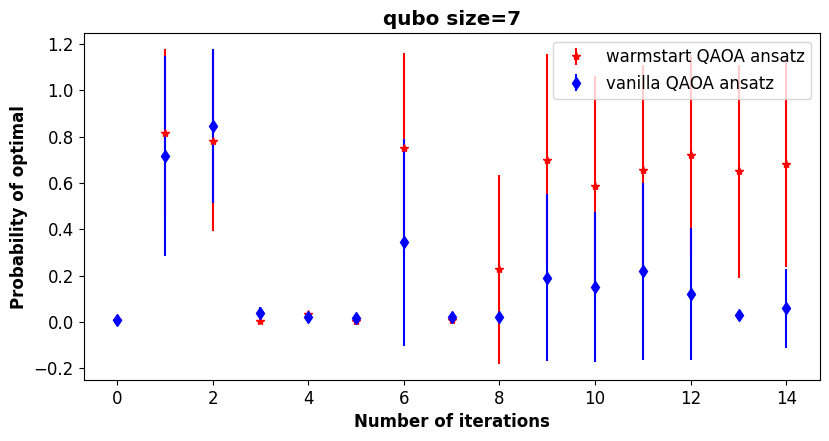

In [51]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.50, 4.50]
plt.rcParams["font.size"] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

for seed in range(5):
    alpha_idx = 0
    number_of_iterations_wsqaoa = list(range(len(prob_opt_sol_wsqaoa_peralpha[alpha_idx][seed][0])))
    number_of_iterations_qaoa = list(range(len(prob_opt_sol_qaoa_peralpha[alpha_idx][seed][0])))
    errorbar_wsqaoa = np.std(prob_opt_sol_wsqaoa_peralpha[alpha_idx][seed], axis=0)
    errorbar_qaoa = np.std(prob_opt_sol_qaoa_peralpha[alpha_idx][seed], axis=0)

    plt.figure()
    plt.errorbar(number_of_iterations_wsqaoa, np.mean(prob_opt_sol_wsqaoa_peralpha[alpha_idx][seed], axis=0), yerr=errorbar_wsqaoa, fmt='*r', label='warmstart QAOA ansatz')
    plt.errorbar(number_of_iterations_qaoa, np.mean(prob_opt_sol_qaoa_peralpha[alpha_idx][seed], axis=0), yerr=errorbar_qaoa, fmt='db', label='vanilla QAOA ansatz')
    plt.legend()
    plt.title(f'qubo size={7}')
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Number of iterations')
    plt.ylabel('Probability of optimal')